In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import warnings
from scipy.signal import find_peaks
warnings.filterwarnings("ignore")

In [2]:
def zscore_2d(matrix):
    matrix_mean = matrix.mean(1, keepdims=True)
    matrix_std = matrix.std(1, keepdims=True)
    return (matrix - matrix_mean) / matrix_std

In [3]:
def get_freq(sampling_rate, level):
    freqs = []
    freq_top = sampling_rate * 0.5
    for i in range(1, level+1):
        start, end = freq_top * 0.5, freq_top
        freqs.append((start, end))
        freq_top = start
    freqs.append((0, freq_top))
    return freqs[::-1]

In [4]:
def load_RealData():
    traindata_path = '../../Data/ctru_20_21_22_23/ctru_20_21_22_23_posture_new_good.npy'

    train_data = np.load(traindata_path)
    signals_train, labels_train = train_data[:, :1000], train_data[:, 1000:]

    return labels_train, zscore_2d(signals_train)

In [5]:
def wavelet_denoise_select(signals, level, wavelet, sampling_rate, show=False):
    filtered_signals = []
    for signal in signals:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dep_freqs = get_freq(sampling_rate, level)

        coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:5] + [np.zeros_like(c) for c in coeffs[5:]]
        reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
        if show:
            print(dep_freqs[1:5])
            plt.figure(figsize=(12, 5))
            plt.plot(signal, label='Noisy Signal')
            plt.plot(reconstructed_signal, label='Filtered Signal')
            plt.legend()
            plt.show()
            break

        filtered_signals.append(reconstructed_signal)
        # break
    return np.array(filtered_signals)

In [6]:
def check_uncertain(signal, window, threshold_uncertain=0.2):
    end = len(signal)
    pieces_indexes = [(start, min(start + window, end)) for start in range(0, end, window)]
    pieced_signals = [signal[begin: over] for begin, over in pieces_indexes]

    def cal_energy(piece):
        return np.sum(np.square(piece))

    pieced_energy = [cal_energy(pieced_signal) for pieced_signal in pieced_signals]

    delta_pieced_energy = np.abs(np.diff(pieced_energy)) / pieced_energy[:-1]
    # delta_pieced_energy = np.array(pieced_energy[1:]) / pieced_energy[:-1]

    if np.sum(delta_pieced_energy <= threshold_uncertain) == len(delta_pieced_energy):
        # 全部符合标准，说明并没有不确定性
        uncertain = 0
    else:
        uncertain = 1

    return uncertain

# for idx in range(0, 300):
#     signal = filtered_signals[idx]
#     delta_energy = check_uncertain(signal, 200)
#
#     zero_crossings = np.where(np.diff(np.sign(signal)))[0]
#     zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
#
#     # print(np.sum(delta_energy <= 0.2))
#     if (np.sum(delta_energy <= 0.2) == len(delta_energy)) and zero_crossings_rate < 0.13:
#         print(delta_energy)
#         print(zero_crossings_rate)
#         plt.figure()
#         plt.plot(filtered_signals[idx])
#         plt.show()

def zcr_and_status(signals, threshold=0.13):
    zcrs, status = [], []

    for cnt, signal in enumerate(signals):
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
        zcrs.append(zero_crossings_rate)

        # 确定是否是uncertain的状态
        uncertain_bool = check_uncertain(signal, window=200)
        if uncertain_bool:
            status.append(-1)
        else:
            if zero_crossings_rate > threshold:
                status.append(0)
            else:
                status.append(1)

    return np.array(zcrs), np.array(status)

In [7]:
def re_status(signals, initial_statuses):
    """I don't need to implement it now."""
    return initial_statuses

def get_good_signals(signals, statuses, zcrs):
    good_signals_idx = []
    for cnt, (status, zcr) in enumerate(zip(statuses, zcrs)):
        if status == 1 and zcr < 0.125:
            good_signals_idx.append(cnt)
    # print(good_signals_idx)
    return signals[good_signals_idx], np.array(good_signals_idx)

In [8]:
from scipy.signal import hilbert
from scipy.signal import savgol_filter

def hilbert_envelope(signals, show=False):
    envelopes = []
    for signal in signals:
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        envelopes.append(amplitude_envelope)

        if show:
            t = np.linspace(0, 1, len(signals[0]), endpoint=False)

            plt.figure(figsize=(10, 3))

            plt.subplot(2, 1, 1)
            plt.plot(t, signal)
            plt.title('signal')

            plt.subplot(2, 1, 2)
            plt.plot(t, amplitude_envelope)
            plt.title('Envelope')

            plt.tight_layout()
            plt.show()
            break
    return np.array(envelopes)


def savgol(signal, window_length=64, order=1):
    filtered_signal = savgol_filter(signal, window_length, order)
    return filtered_signal

def smooth_envelopes(envelopes, window=64):
    smoothed_envelopes = []
    for envelope in envelopes:
        smoothed_envelope = savgol(envelope, window_length=window)
        smoothed_envelopes.append(smoothed_envelope)
    return np.array(smoothed_envelopes)

In [9]:
# acf
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    acf = np.correlate(signal - mean, signal - mean, mode='full') / (np.var(signal) * n)
    return acf[n-1:]

def get_acfs(envelopes):
    acfs = []
    for env in envelopes:
        acf = autocorrelation(env)
        acfs.append(acf)
    return np.array(acfs)

In [11]:
labels_train, signals_train = load_RealData()
wavelet = 'db12'
level = 6
sampling_rate = 100

filtered_signals = wavelet_denoise_select(signals_train, level, wavelet, sampling_rate)

print(filtered_signals.shape)
zcrs, statuses = zcr_and_status(filtered_signals)

final_statuses = re_status(filtered_signals, statuses)
good_signals, good_signals_index = get_good_signals(filtered_signals, final_statuses, zcrs)
print(good_signals.shape)
good_labels = labels_train[good_signals_index]
print(good_labels.shape)


(50884, 1000)
(1738, 1000)
(1738, 7)


In [23]:
data = np.concatenate((good_signals, good_labels), axis=1)

In [43]:
data_0 = data[data[:, -1] == 0.0]
data_1 = data[data[:, -1] == 1.0]
data_2 = data[data[:, -1] == 2.0]
data_3 = data[data[:, -1] == 3.0]

data_0.shape, data_1.shape, data_2.shape, data_3.shape

((717, 1007), (231, 1007), (375, 1007), (415, 1007))

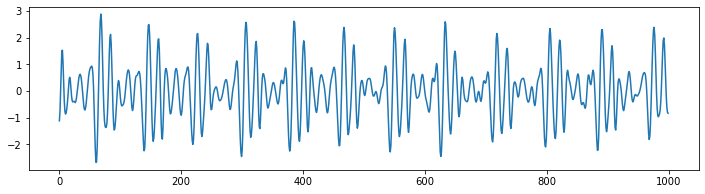

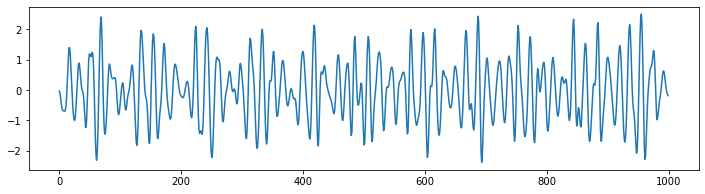

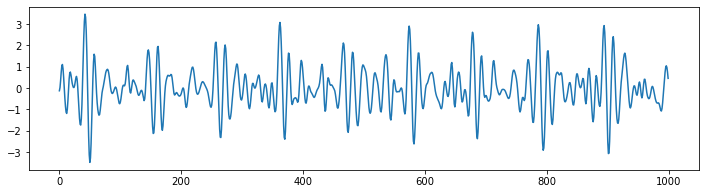

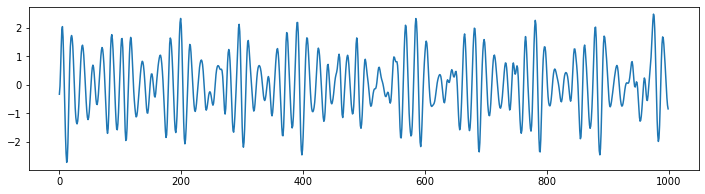

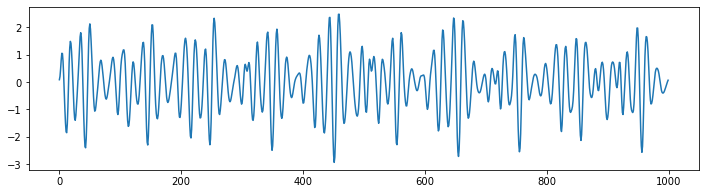

In [31]:
for cnt in range(5):
    plt.figure(figsize=(12, 3))
    plt.plot(data_0[cnt, :1000])
    plt.show()


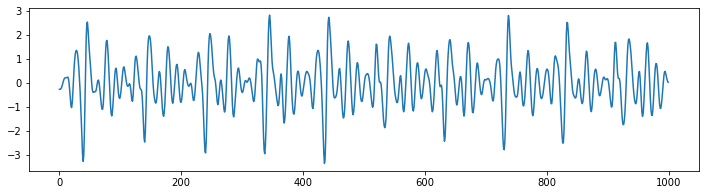

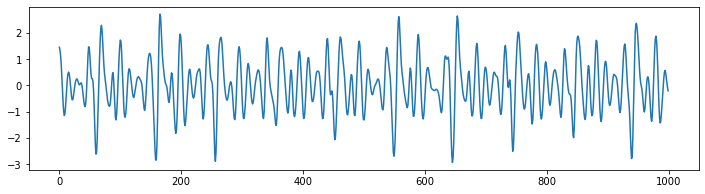

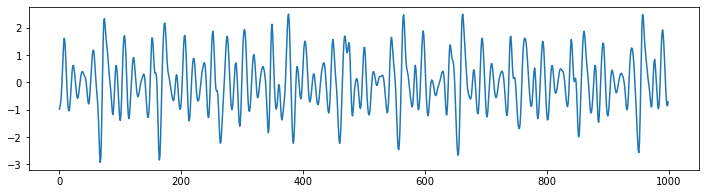

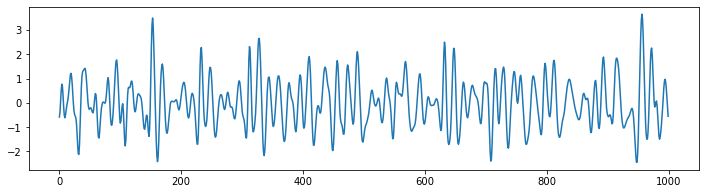

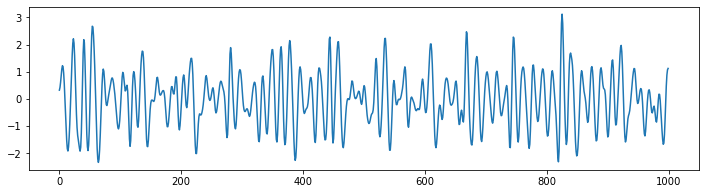

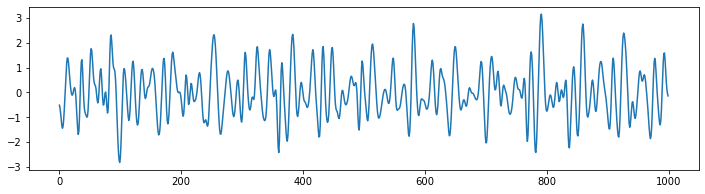

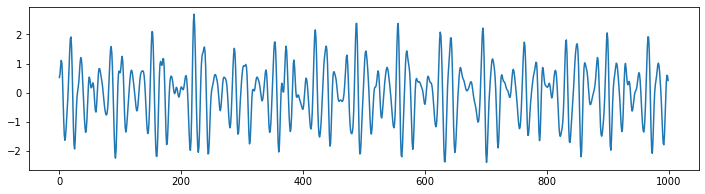

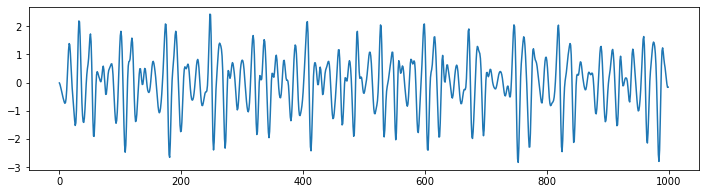

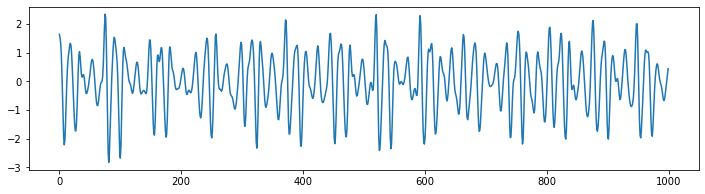

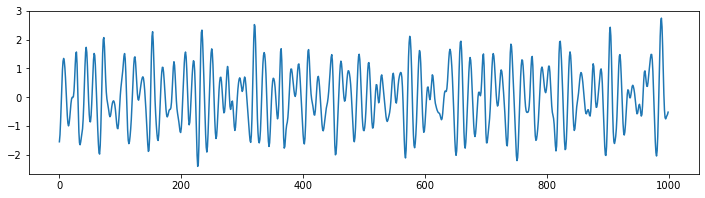

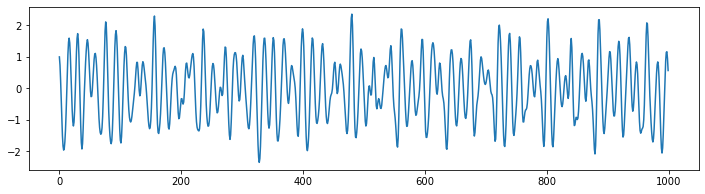

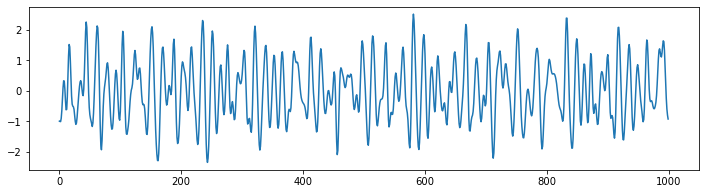

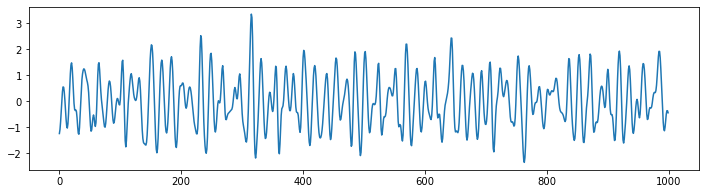

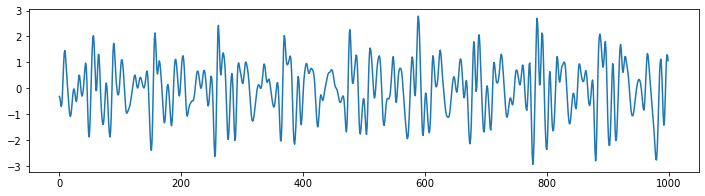

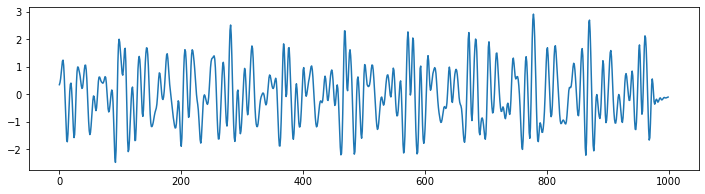

In [41]:
for cnt in range(15):
    plt.figure(figsize=(12, 3))
    plt.plot(data_1[cnt, :1000])
    plt.show()

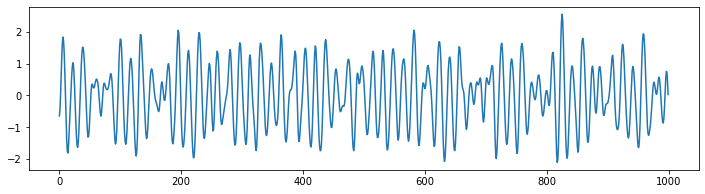

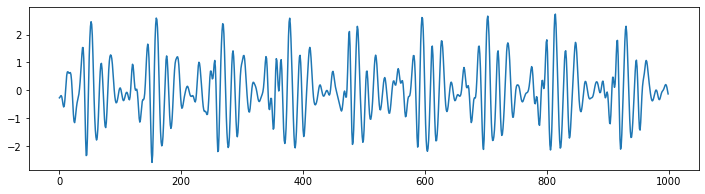

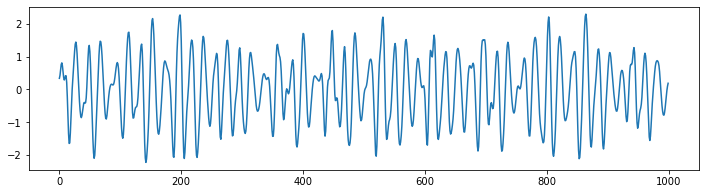

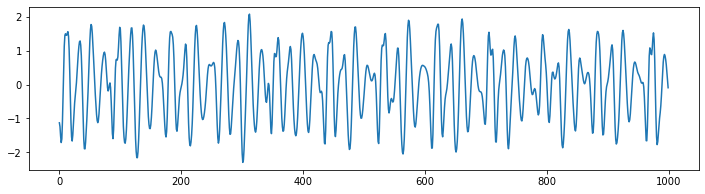

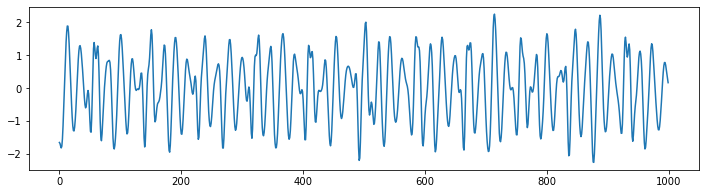

In [33]:
for cnt in range(5):
    plt.figure(figsize=(12, 3))
    plt.plot(data_2[cnt, :1000])
    plt.show()

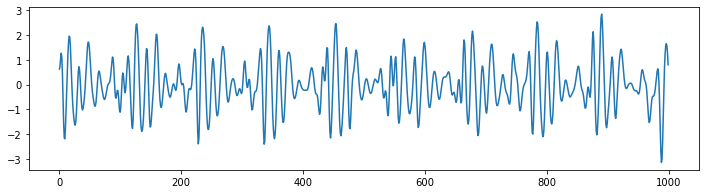

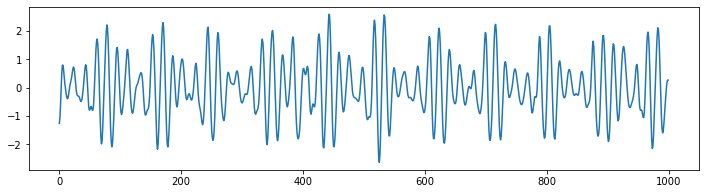

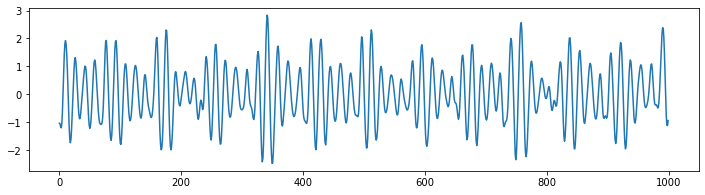

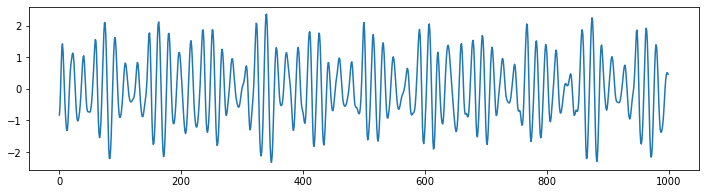

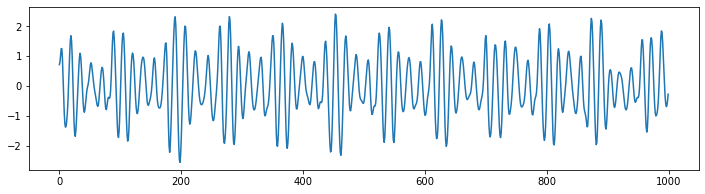

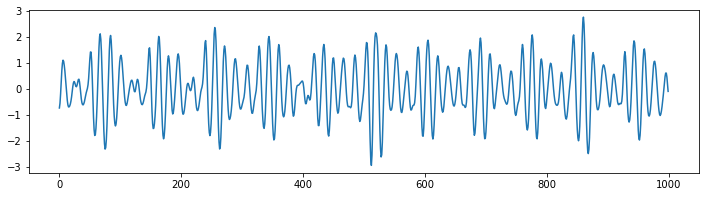

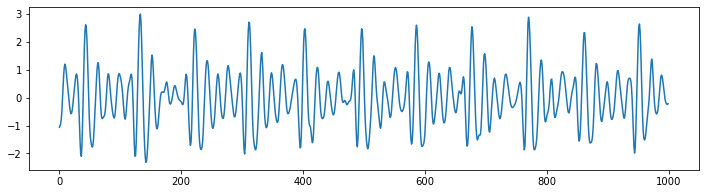

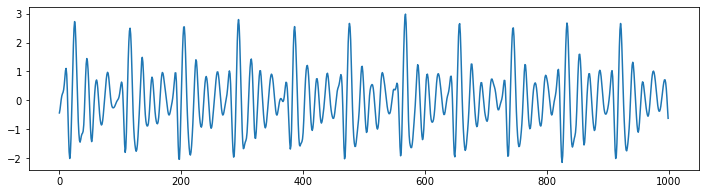

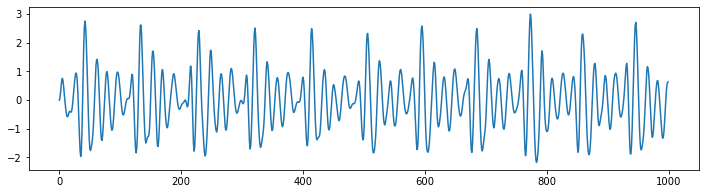

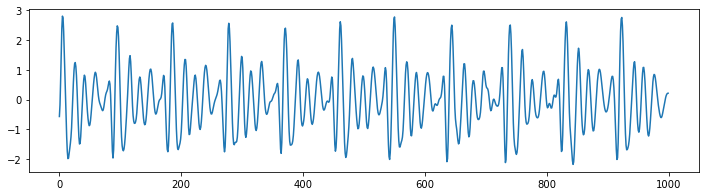

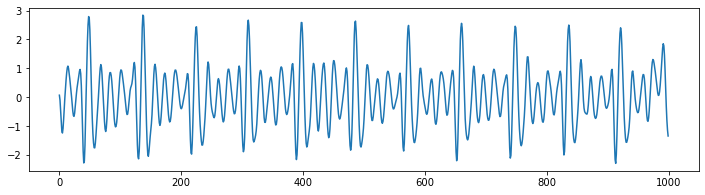

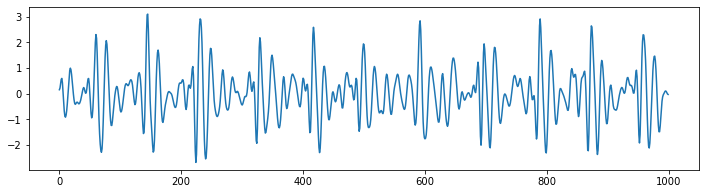

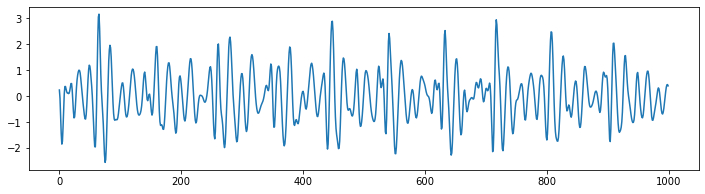

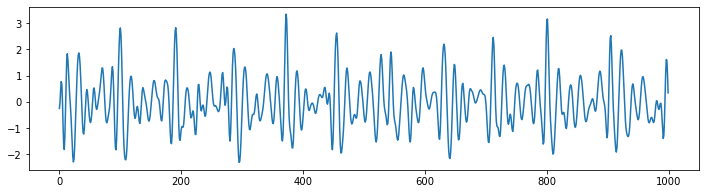

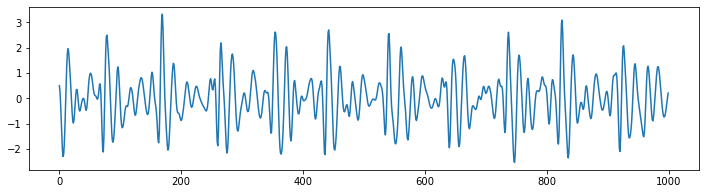

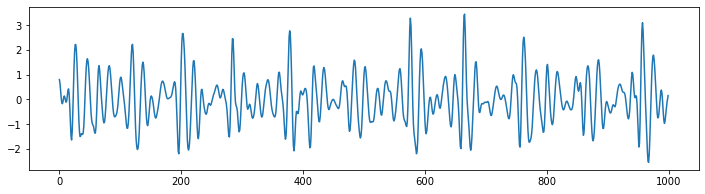

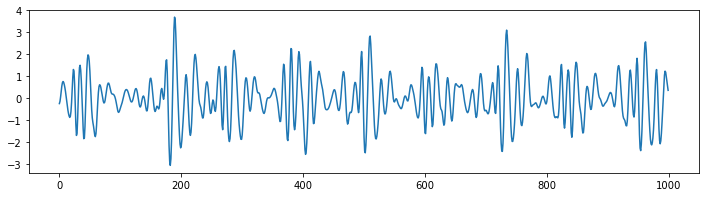

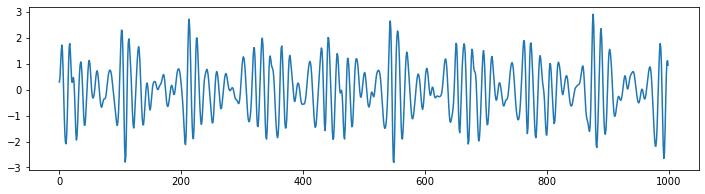

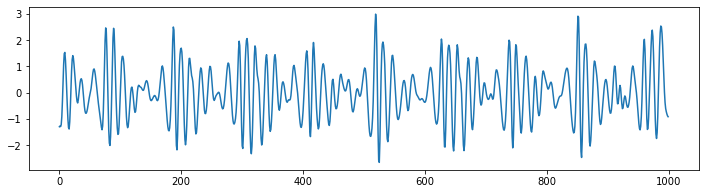

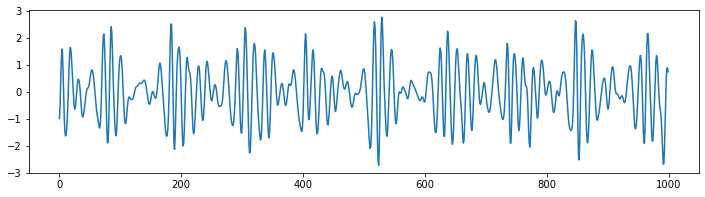

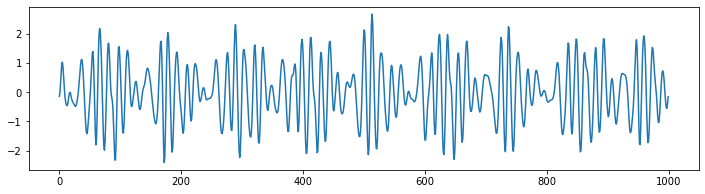

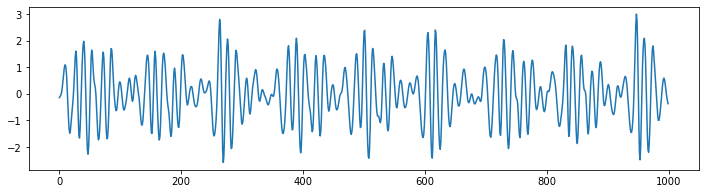

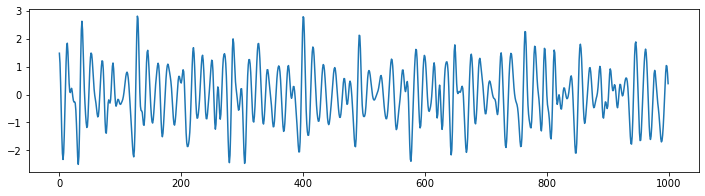

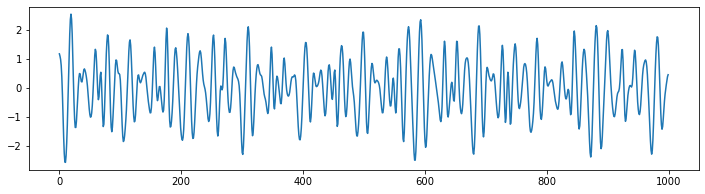

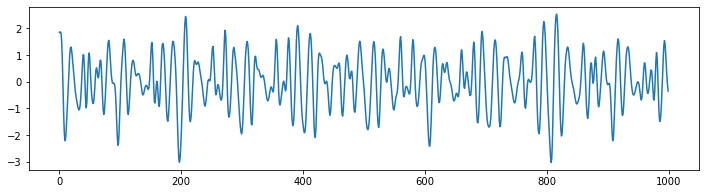

In [44]:
for cnt in range(25):
    plt.figure(figsize=(12, 3))
    plt.plot(data_3[cnt, :1000])
    plt.show()